<a href="https://colab.research.google.com/github/elle-ctrl/blog/blob/main/CS_Elle_Le.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
## 1 - Overview

*   1.1. Business Context & KPIs
*   1.2. Key Findings
*   1.3. Future Considerations 

## 2 - Modeling

*   1. EDA
##### 1.1. Check the data for any abnormality
##### 1.2. Clean and Do feature engineering
*   2. Fit conventional classifiers as baseline models
*   3. Tuned to get better models


-------------------------------------------------------------------------------

# 1 - Overview
*   1.1. Business Context & KPIs

Problem:  to identify the likelihood to default in the next month for customers, given data such as: user characteristics (e.g. gender, education level, marrital status, age), and user financial behavior (e.g. total credit line, payment amount in the last 6 months, and on-time payment status in the last 6 months). It is important to note that we must not discriminate users based on race, color, religion, sex, marital status, age (provided the applicant has the capacity to contract), national origin, or receipt of public assistance.

Use Cases: given Credit Sesame's mission to empower people to take charge of their credit and loans and achieve their financial goals, the prediction of user's likelihood of being default has a number of applications. For example: to suggest the appropriate credit cards, with the new Sesame Cash, this feature can be use to determine appropriate promotion, incentive to encourage user adoption and usage of our product, etc. 
Goals 

KPIs: 

This is a classification problem with imbalanced distribution of classes.
In this dataset, there is around 22% of users with label default, and 78% not.
Therefore, the suitable metrics should be Precision, Recall, and F1, definetly not accuracy (because a model that always predicts all points as the majority class will have accuracy score of 78%). 
Deciding which metric to use totally depends on business and ethical consideration. 

We can analyze the cost of False Positive (FP) and False Negative(FN). If the cost of FP is higher, we will optimize Precision because Precision = TP / (TP + FP) and vice versa. (Recall = TP/ (TP + FN) ). Once can choose F1 (the harmonic of Precision and Recall) as a lazy method, but I always prefer to specific Precision or Recall clearly.

This our case, let's examine the precision-recall trade-off. False Positive means a customer is not default but we say they are. The cost is that we lose the potential revenue from this customer because we already excluded them from product offering. Also, customer might be hurt, and discouraged to use other products we offer. False Negative is that we thought a customer is not default, but they actually are. The cost here is the bad debt incurred. 

My assumption is Credit Sesame is in the growth stage, and we can afford some risks. We do not want to miss out customers. Thus, precision is more important. Precision will be our North Star metric to evaluate models in this case.

Noted that ROC and its AUC are two other common performance metrics for classification models. However, they are not responsive for imbalanced classes. Precision - Recall curve is a more appropriate measurement. We can use AUC under Precision - Recall curve as well. 

*   1.2. Key Findings 

Data Overview: The data is pretty clean, no NA, minor discrepancy in some columns but easy to fixed. 
- There are some correlation between education, age, credit line, and payment bahavior to the likelihood of default. Nothing is out of ordinary: users with higher education leval have lower probability of default, etc.

Data is split into 70% train and 30% test, stratified by classes to maintain the same distribution of classes across the data sets.

After some data exploratory, some classifiers were fitted as baseline models
- Logistic Regression with class-weight of balance.
- Decition Tree
- Random Forest
- XGBoost - best performance with little overfit. Precision of 0.7 train, 0.68 Test, while Recall 0.37 Train and 0.35 Test

Their performance is summary in a table at the end of this notebook. Random Forest is useful to get feature importance. The 10 most important features are: 'PAY_0',
 'PAY_2',
 'PAY_5',
 'PAY_3',
 'PAY_4',
 'PAY_AMT1',
 'LIMIT_BAL',
 'BILL_AMT1',
 'PAY_AMT2',
 'BILL_AMT2'

Model tunning🇰
- Logistic Regression: adjusting class weight improve model performance significantly. A common practice for using the class weighting is to use the inverse of the class distribution present in the training dataset. When the class_weights = ‘balanced’, the model automatically assigns the class weights inversely proportional to their respective frequencies. We tried this as a baseline model. Looks like the balance one is the best
- Randome Forest: {'max_depth': 7, 'random_state': 10, 'n_estimators': 100}
- XGBoost: {'max_depth': 7, 'learning_rate': 0.01}

The best model
We can pick either Random Forest or XGBoost. They both achieve 0.68 precision and 0.32 recall on test data with just litte overfit.

Inferences: 0.68 precision means that when we say a user is likely to default, 68% of the time we are correct. 32% recall means that we are able to identify 32% of the defaults from the sample. Which is a decent result and totally aligns with out goal stated earlier.

*   1.3. Future Considerations 
- Hyperparameter tuning for XGBoost instead of estimating the parameters.
- Use cross validation
- Adjust decision threshold from the default of 0.5
- Feature Engineering (maybe some interaction terms)
- Collect more data: such as cross-card usage.

In [73]:
# Summary of our model performance.
result_df

,Model,Classifier,Features,Precision- Train,Precision- Test,Recall- Train,Recall- Test,F1- Train,F1- Test
0,Logistic Regression - Base (balance weight),LogisticRegression(class_weight='balanced'),"LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.320725,0.318373,0.354144,0.342039,0.336607,0.329782
1,Decision Tree - Base,"DecisionTreeClassifier(max_depth=10, random_st...","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.758669,0.607908,0.471044,0.370668,0.581219,0.460530
2,Random Forest - Base,"(DecisionTreeClassifier(max_depth=10, max_feat...","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.845065,0.676142,0.436814,0.334505,0.575930,0.447581
3,XGBoost - Base,XGBClassifier(),"LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.704323,0.677800,0.371798,0.346560,0.486685,0.458624
0,Logistic Regression - Tuned,"LogisticRegression(class_weight={0: 1, 1: 10})","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.228387,0.229090,0.965124,0.964340,0.369366,0.370228
1,Random Forest - Tuned,"(DecisionTreeClassifier(max_depth=7, max_featu...","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.751479,0.684268,0.355436,0.312406,0.482607,0.428966
2,XGBoost - Tuned,"XGBClassifier(learning_rate=0.01, max_depth=7)","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.757676,0.679112,0.393111,0.338021,0.517647,0.451375


#2 - Modeling

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
import xgboost as xgb

#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline
plt.style.use('seaborn-white')

In [ ]:
# Read in the data
df = pd.read_excel('/content/gdrive/My Drive/ISL_data/default of credit card clients.xlsx')

In [ ]:
# Shorten the name of the target column, just to make it simpler.
df.rename(columns={'default payment next month':'default'}, inplace=True)

## EDA

In [ ]:
# Get some basic details about the data. E.g. Checking for null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [ ]:
# Check for the ranges.
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## See if there is any abnormal values.
Let's see if there is any value of the categorical variables that is not described in the deta overview.

In [ ]:
# Unbalanced distribution of classes:
df['default'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default, dtype: float64

#### EDUCATION
 (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

In [ ]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [ ]:
df['EDUCATION'].replace(to_replace=[0,5,6], value=4, inplace=True)
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

#### MARRIAGE
Marital status (1=married, 2=single, 3=others)

In [ ]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [ ]:
df['MARRIAGE'].replace(to_replace=[0], value=3, inplace=True)
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

### Pay_0
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- Noted that we have 9% of -2 value, and 50% of 0 in the data and no description provided for these values. Similar to the rest of PAY columns.
- Action: Assume -1, -2, and 0 mean on time payment (some customers paid early, causing -2 value?)

In [ ]:
df['PAY_0'].value_counts(normalize=True)

 0    0.491233
-1    0.189533
 1    0.122933
-2    0.091967
 2    0.088900
 3    0.010733
 4    0.002533
 5    0.000867
 8    0.000633
 6    0.000367
 7    0.000300
Name: PAY_0, dtype: float64

In [ ]:
df['PAY_3'].value_counts()

 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64

In [ ]:
# Replace all minus values with 0 to indicate on time payment
for col in ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']: 
  df[col].replace(to_replace=[-1,-2], value=0, inplace=True)

### BILL_AMT1-6
Amount of bill statement in September, 2005 (NT dollar) till April, 2005.
- There are negative values. Consider them as credits?

In [ ]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


### PAY_AMT1-6
Amount of previous payment in September, 2005 (NT dollar) to April, 2005.
All looks good. No abnormal value.

In [ ]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [ ]:
# Group ages into groups
bins = [21,30,40,50,60,80]
labels = [1,2,3,4,5]
df['age_bin'] = pd.cut(df['AGE'], bins=bins,labels = labels, include_lowest=True).astype(int)
df.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
age_bin      int64
dtype: object

## Some graphs

#### Credit Limit
Most common value: around 50k

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


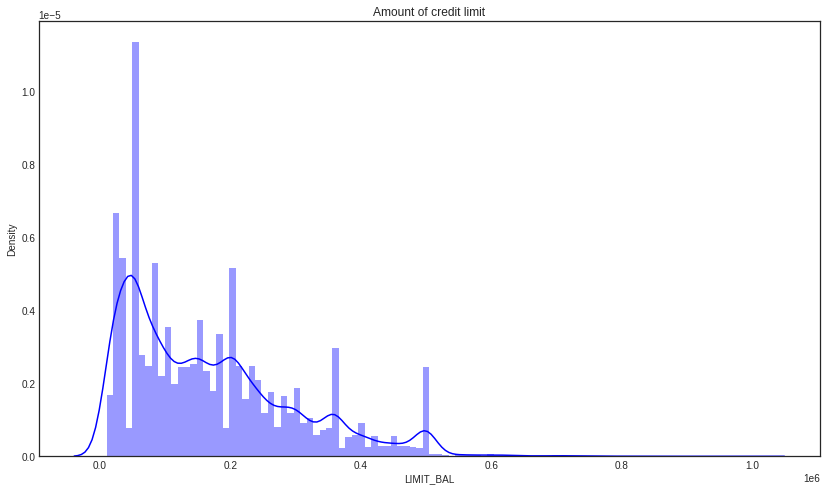

In [ ]:
plt.figure(figsize = (14,8))
plt.title('Amount of credit limit')
sns.set_color_codes("pastel")
sns.distplot(df['LIMIT_BAL'],kde=True,bins=100, color="blue")
plt.show()

#### Credit limit vs. sex
No significant difference between two genders (1-male, 2-female)

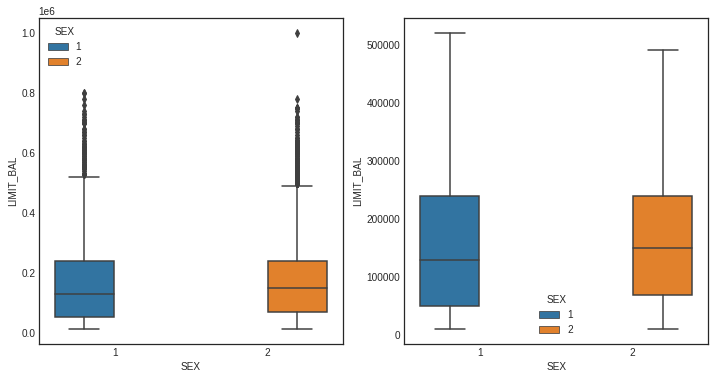

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
# Show outliers outside of the caps
s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=df,showfliers=True)

# Without outliers
s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=df,showfliers=False)
plt.show()

#### Default vs Sex
Female seems to be more likely to default

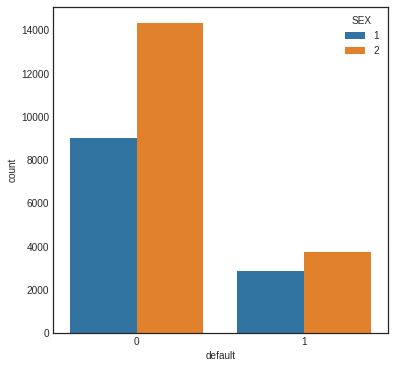

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
data = df[['default','SEX']]
sns.countplot(x='default', hue='SEX', data=data)
plt.show()

#### Customers with graduate education is not likely to default.

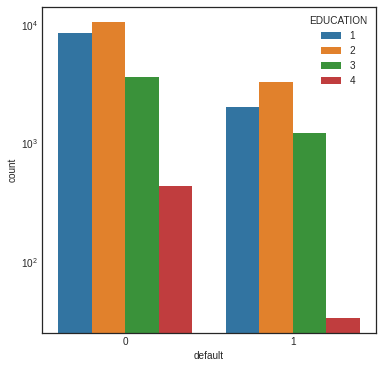

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
data = df[['default','SEX']]
g = sns.countplot(x='default', hue='EDUCATION', data=df)
g.set_yscale("log")
plt.show()

#### Marriage status seems not to have a significant impact on credit risk.

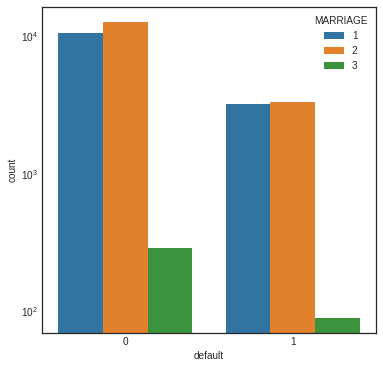

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
data = df[['default','SEX']]
g = sns.countplot(x='default', hue='MARRIAGE', data=df)
g.set_yscale("log")
plt.show()

#### Younger customers seem to have a higher likehood of being default.

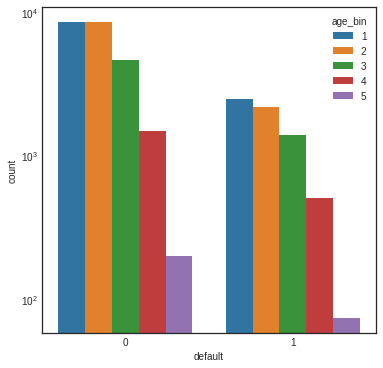

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
data = df[['default','SEX']]
g = sns.countplot(x='default', hue='age_bin', data=df)
g.set_yscale("log")
plt.show()

#### Summary in a correlation matrix

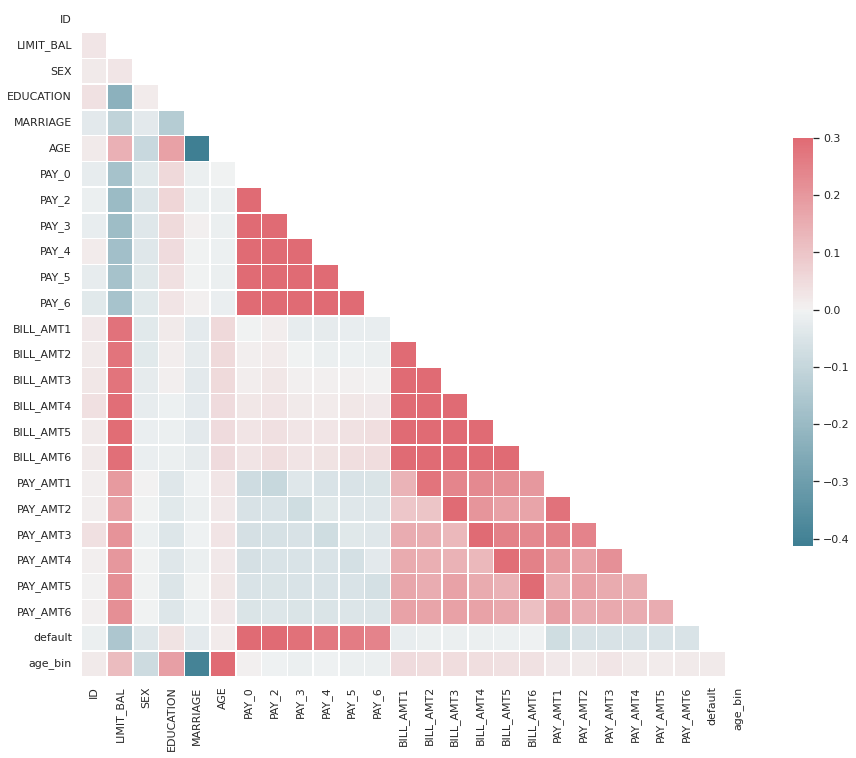

In [ ]:
#correlation matrix
sns.set(style="white")

# Compute the correlation matrix
corrmat = df.corr() # corr calculation

# Create a white mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, mask=mask, 
            cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Fit conventional classifiers as baseline models

In [ ]:
# Split the data into train and test sets. Stratify by y to maintain the same distribution of classes in two sets.
y=df[['default']]
X=df.drop(columns=['default', 'AGE','ID']) # use age_bin instead
data = train_test_split(X, y, train_size = 0.7, random_state = 100, stratify=y)

In [ ]:
# A class to wrap all training and reporting tasks for selected models. 
class ModelList():

  def __init__(self, data):
    # Init
    self.data = data
    self.X_train, self.X_test, self.y_train, self.y_test = data
    self.model_list = {}

  def add_model(self, model_name, model, params):
    # Add model to the list of testing models
    self.model_list[model_name] = model(**params)

  def fit(self):
    # Fit the model
    for model_name, model in self.model_list.items():
      model.fit(X_train, y_train.values.ravel())

  def evaluate(self, model):
    # Calculate performance metrics for each model
    X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_cm = confusion_matrix(y_train, y_pred_train)
    test_cm = confusion_matrix(y_test, y_pred_test)

    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    metrics = precision_train, precision_test, recall_train, recall_test, f1_train, f1_test
    cm = train_cm, test_cm
    return metrics, cm

  def report(self):
    # Record the report to the evaluation dataframe
    eval_df = pd.DataFrame({'Model': [],
                              'Classifier':[],
                              'Features':[],
                              'Precision- Train':[],
                              'Precision- Test':[],
                              'Recall- Train':[],
                              'Recall- Test':[],
                              'F1- Train':[],
                              'F1- Test':[]
                              })
    
    cms = {}
    for model_name, model in self.model_list.items():
      metrics, cm = self.evaluate(model)
      # Add to the evaluation report
      r = eval_df.shape[0]
      eval_df.loc[r] = [model_name, model, ', '.join(self.X_train.columns), *metrics]
      cms[model_name] = cm
    return eval_df, cms

  def get_feature_importance(self, model_name, k=10):
    # Get top k most important features
    importances = dict(zip(X_train.columns, self.model_list[model_name].feature_importances_))
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    return sorted_importances[:k]

In [ ]:
# Train a number of models with the most basic form of hyperparameters.
# These models are considered as the baseline for us to evaluate later models.

ml = ModelList(data)
model_names = ['Logistic Regression - Base (balance weight)',
               'Decision Tree - Base', 'Random Forest - Base',
               'XGBoost - Base']

models = [LogisticRegression,
          DecisionTreeClassifier, RandomForestClassifier, 
          xgb.XGBClassifier]

params = [{'class_weight': 'balanced'},
          {'max_depth': 10, 'random_state': 10}, {'max_depth': 10}, {}]

for model_name, model, param in zip(model_names, models, params):
  ml.add_model(model_name, model, param)

ml.fit()
eval_df_base, cm_base = ml.report()
eval_df_base.round(2)

,Model,Classifier,Features,Precision- Train,Precision- Test,Recall- Train,Recall- Test,F1- Train,F1- Test
0,Logistic Regression - Base (balance weight),LogisticRegression(class_weight='balanced'),"LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.32,0.32,0.35,0.34,0.34,0.33
1,Decision Tree - Base,"DecisionTreeClassifier(max_depth=10, random_st...","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.76,0.61,0.47,0.37,0.58,0.46
2,Random Forest - Base,"(DecisionTreeClassifier(max_depth=10, max_feat...","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.85,0.68,0.44,0.33,0.58,0.45
3,XGBoost - Base,XGBClassifier(),"LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.70,0.68,0.37,0.35,0.49,0.46


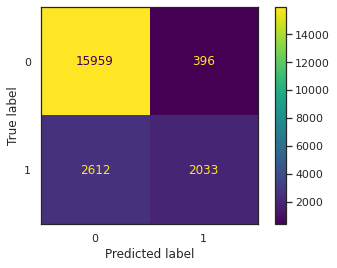

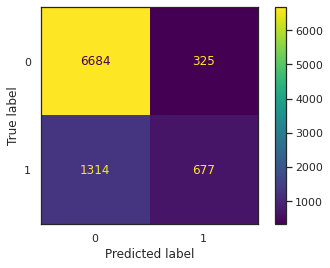

In [ ]:
# Plot confusion matrix for Random Forest - Base, both train and test data.
from sklearn.metrics import ConfusionMatrixDisplay
disp_train = ConfusionMatrixDisplay(cm['Random Forest - Base'][0])
disp_test = ConfusionMatrixDisplay(cm['Random Forest - Base'][1])
disp_train.plot()
disp_test.plot()
plt.show()

In [ ]:
# Get the top 10 important features:
[ i[0] for i in ml.get_feature_importance('Random Forest - Base')]

['PAY_0',
 'PAY_2',
 'PAY_5',
 'PAY_3',
 'PAY_4',
 'PAY_AMT1',
 'LIMIT_BAL',
 'BILL_AMT1',
 'PAY_AMT2',
 'BILL_AMT2']

##  Tuned to get better models

### Tune Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

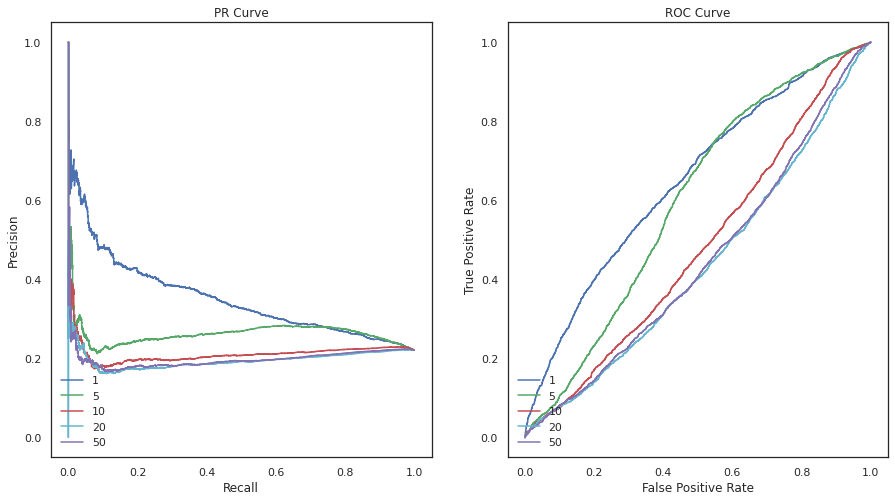

In [ ]:
# Plot Precision-Recall curve at different weight ratios.
# ROC is for reference only.
X_train, X_test, y_train, y_test = data

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = metrics.roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

## Tune Random Forest
Random Forest Hyperparameters we’ll be Looking at below two, as they usually have the strongest effect in improving model perforamce.
- max_depth
- n_estimators


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

X_train, _, y_train, _ = data

n_estimators = [50, 100]
max_depth = [5, 7, 10]

rf = RandomForestClassifier()

hyperF = {'n_estimators' : n_estimators, 
          'max_depth' : max_depth
          }

gridF = GridSearchCV(rf, hyperF, cv = 3, scoring = precision_score, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  category=UserWarning,


In [ ]:
# Get the best hyperparameters:
fgridF.best_params_

In [ ]:
y_test_pred_best = gridF.best_estimator_.predict(X_test)
f1_score(y_test, y_test_pred_best)

0.45830553702468313

## Tune XGBoost

In [70]:
# Train the tuned models
# These models are considered as the baseline for us to evaluate later models.

ml = ModelList(data)
model_names = ['Logistic Regression - Tuned',
               'Random Forest - Tuned',
               'XGBoost - Tuned']

models = [LogisticRegression, 
          RandomForestClassifier, 
          xgb.XGBClassifier]

params = [{'class_weight': {0:1,1:10}},
          {'max_depth': 7, 'random_state': 10, 'n_estimators': 100}, 
          {'max_depth': 7, 'learning_rate': 0.01}]
          
for model_name, model, param in zip(model_names, models, params):
  ml.add_model(model_name, model, param)

ml.fit()
eval_df_tuned, cm_tuned = ml.report()
eval_df_tuned

,Model,Classifier,Features,Precision- Train,Precision- Test,Recall- Train,Recall- Test,F1- Train,F1- Test
0,Logistic Regression - Tuned,"LogisticRegression(class_weight={0: 1, 1: 10})","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.228387,0.229090,0.965124,0.964340,0.369366,0.370228
1,Random Forest - Tuned,"(DecisionTreeClassifier(max_depth=7, max_featu...","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.751479,0.684268,0.355436,0.312406,0.482607,0.428966
2,XGBoost - Tuned,"XGBClassifier(learning_rate=0.01, max_depth=7)","LIMIT_BAL, SEX, EDUCATION, MARRIAGE, PAY_0, PA...",0.757676,0.679112,0.393111,0.338021,0.517647,0.451375


In [74]:
# Add both baseline models and the tuned ones.
result_df = pd.concat([eval_df_base, eval_df_tuned], axis=0)